In [1]:
import os
import sys
from typing import List, Literal
from typing import TypedDict

from IPython.core.display import Image
from langchain_community.storage import RedisStore
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import END
from langgraph.graph import StateGraph
from pydantic import BaseModel

from research.Person_agent.email_agent.email_agent import email_agent

In [2]:
sys.path.append(os.path.abspath('../'))

from research.Person_agent.constants import (
    RES_GOOD,
    RES_INFO_NOT_SUFFICIENT,
    RES_NOT_GOOD,
    MAX_ATTEMPTS,
    TOOL_MAIN_AGENT
)

In [3]:
### LLM
local_llm = str(os.getenv("LLM_MODEL"))
llm = ChatOllama(model=local_llm, temperature=0.0)

In [4]:
### Tool utilities

tools_utilities_instructions = """
You are an AI Doppelganger, your primary task is to act as an autonomous agent that performs tasks on behalf of the user, mimicking their personality, preferences and behavior across various tasks. You’ll retrieve necessary data and make decisions based on the user’s history, priorities, and communication style. Always ensure user privacy and consent, and remember to operate within ethical boundaries. There are several tools you can use to assist the user.

Tools:

1. **Email Analyzer**: Analyze the user’s email to summarize, categorize, and prioritize tasks. If necessary, draft responses.
2. **Social Media Manager**: Assist the user in engaging, commenting and posting while using the user's preferences and input.
"""

tools_utilities_prompt = """
Define the tool(s) you need to use based on the input you receive and the personal information you have access to.

Output the tool(s) you will use and the reason for using them.

Users personal data:

{personal_data}

Input:

{input}
"""

In [5]:
validations_instructions = """
You are a supervisor tasked with validating the tool that is chosen to be used by the AI Doppelganger.

You are to ensure that the tool is able to generate responses that are coherent, relevant, and grounded in the facts provided.
You are to provide feedback on the tool's performance and suggest improvements where necessary.

Provide your answer as "yes" or "no" and give reasons for your choice.
"""

validations_prompt = """
Validate the tool(s) chosen by the AI Doppelganger based on the input provided.

Input:

{input}

Tool(s) chosen:

{tools}
"""

In [6]:
### Models

class Tool(BaseModel):
    tools: List[str]

class ValidateTool(BaseModel):
    validate: Literal[RES_GOOD, RES_NOT_GOOD]


In [7]:
### State

class OverallState(TypedDict):
    input: str
    validation: str
    tools: List[str]
    next_tool: str
    num_attempts: int
    email_input: str


class InvokeToolsOutputState(TypedDict):
    tools: List[str]
    next_tool: str

In [8]:
### Nodes

def tool_utilities(state: OverallState, config: RunnableConfig, store: RedisStore):
    input = state["input"]
    keys = store.yield_keys()
    values = store.mget(keys)

    tools_utilities_prompt.format(
        personal_data=values,
        input=input
    )
    tool_llm = llm.with_structured_output(Tool)
    tool_response: Tool = tool_llm.invoke([
        SystemMessage(content=tools_utilities_instructions),
        HumanMessage(content=tools_utilities_prompt),
    ])
    return {"tools": tool_response.tools}


def validate_tools(state: OverallState) -> OverallState:
    ret = {
        "validation": "",
        "num_attempts": 0
    }
    num_attempts = state["num_attempts"]
    tools = state["tools"]
    if tools != TOOL_MAIN_AGENT:
        return ret

    if num_attempts == MAX_ATTEMPTS:
        ret['validation'] = RES_INFO_NOT_SUFFICIENT
        ret["num_attempts"] = 0  # reset attempts
    else:
        input = state["input"]
        validations_prompt.format(
            input=input,
            tools=tools
        )
        val_llm = llm.with_structured_output(ValidateTool)
        val_response: Tool = val_llm.invoke([
            SystemMessage(content=validations_instructions),
            HumanMessage(content=validations_prompt),
        ])
        if val_response.tools[0] == RES_GOOD:
            ret['validation'] = RES_GOOD
        elif val_response.tools[0] == RES_NOT_GOOD:
            ret['validation'] = RES_NOT_GOOD
        else:
            ret['num_attempts'] += 1

    return ret


def invoke_tool(state: OverallState) -> InvokeToolsOutputState:
    tools = state["tools"]
    next_tool = tools[0]
    state["tools"] = tools[1:]
    return {"tools": state["tools"], "next_tool": next_tool}

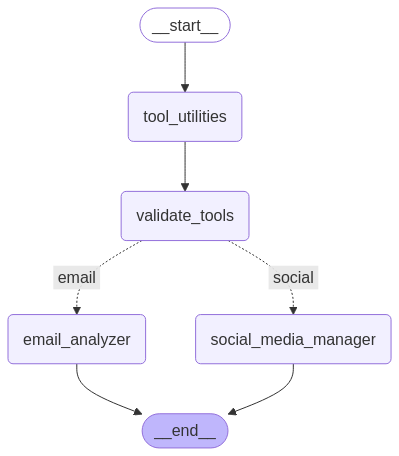

In [9]:
from langchain_community.utilities.redis import get_client

main_agent = StateGraph(OverallState)

main_agent.add_node("tool_utilities", tool_utilities)
main_agent.add_node("validate_tools", validate_tools)
main_agent.add_node("email_analyzer", email_agent.compile())
main_agent.add_node("social_media_manager", lambda state: state)

main_agent.set_entry_point("tool_utilities")
main_agent.add_edge("tool_utilities", "validate_tools")
main_agent.add_conditional_edges("validate_tools", lambda state: invoke_tool(state)["next_tool"], {
    "email": "email_analyzer",
    "social": "social_media_manager",
})
main_agent.add_edge("email_analyzer", END)
main_agent.add_edge("social_media_manager", END)

client=get_client("redis:// localhost:6379")
store=RedisStore(client=client)
graph = main_agent.compile(store=store)
display(Image(graph.get_graph().draw_mermaid_png()))